# Genetic algorithm model calibration

This notebook applies a genetic algorithm to calibrate wall decay coefficients using data from each water quality sensing period.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly
from bayesian_wq_calibration.simulation import build_model, epanet_simulator, sensor_model_id
from bayesian_wq_calibration.ga import evaluate, decision_variables_to_dict
from bayesian_wq_calibration.constants import TIMESERIES_DIR, RESULTS_DIR
import random
from deap import base, creator, tools, algorithms
from functools import partial
import multiprocessing
import time

### Load data and build water model

Load operational data for selected sensing period.

In [2]:
data_period = 19 # 19 calibration events (as at 30 September 2024)
try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
    print(f"Calibrating wall model decay coefficients for data period: {data_period}...")
except:
    print(f"Data period {data_period} does not exist.")

Calibrating wall model decay coefficients for data period: 19...


Split sensing data into train and test datasets.

In [3]:
n_total = len(flow_df['datetime'].unique())
n_train = 7 * 24 * 4

train_range = range(n_train)
train_datetime = flow_df['datetime'].unique()[list(train_range)]

test_range = range(n_train, n_total)
test_datetime = flow_df['datetime'].unique()[list(test_range)]

total_range = range(n_total)
total_datetime = flow_df['datetime'].unique()[list(total_range)]

Build water model via WNTR module.

In [4]:
wn_train = build_model(flow_df[flow_df['datetime'].isin(train_datetime)], pressure_df[pressure_df['datetime'].isin(train_datetime)], cl_df[cl_df['datetime'].isin(train_datetime)], sim_type='chlorine', demand_resolution='wwmd')

Set grouping type and initialize wall decay coefficients.

In [5]:
grouping = 'material'
wall_coeffs_ub = -5.0
wall_coeffs_lb = 0.0

if grouping == 'single':
    n_coeffs = 1
elif grouping == 'material':
    n_coeffs = 3
elif grouping == 'material-diameter':
    n_coeffs = 6
elif grouping == 'roughness':
    n_coeffs = 8

### Initialize GA using DEAP module.

Assign default parameters.

In [6]:
popsize = 40
ngen = 50
cxpb = 0.7
mutpb = 0.15
tournsize = 3
hofsize = 1

Set up DEAP structures.

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # minimize objective function
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, wall_coeffs_lb, wall_coeffs_ub)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_coeffs)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("select", tools.selTournament, tournsize=tournsize)
# pool = multiprocessing.Pool()
# toolbox.register("map", pool.map)

### Run GA

In [8]:
def main(wn, cl_df, grouping):
    
    start_time = time.time()
    
    # preload data into the evaluation function
    evaluation_function = partial(evaluate, wn=wn, cl_df=cl_df, grouping=grouping)
    toolbox.register("evaluate", evaluation_function)

    # define statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("mean", np.mean)
    stats.register("min", np.min)

    # initialize GA parameters
    pop = toolbox.population(n=popsize)
    hof = tools.HallOfFame(hofsize)
    logbook = tools.Logbook()  # Initialize logbook

    # set early stopping criteria
    previous_best_fitness = np.inf
    stagnant_gens = 0
    max_stagnant_gens = 8

    # run GA
    for g in range(ngen):
        
        if g != 0:
            pop = toolbox.select(pop, k=len(pop))
            pop = algorithms.varAnd(pop, toolbox, cxpb=cxpb, mutpb=mutpb)
        
        # evaluate the individuals with invalid fitness
        invalids = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalids)
        for ind, fit in zip(invalids, fitnesses):
            ind.fitness.values = fit

        # update hall of fame and compile statistics
        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=g, nevals=len(invalids), **record)
        if g == 0:
            print(logbook.stream)
        else:
            print(logbook.stream.splitlines()[-1])

        # check for improvement in fitness
        current_best_fitness = hof[0].fitness.values[0]
        if current_best_fitness < previous_best_fitness:
            previous_best_fitness = current_best_fitness
            stagnant_gens = 0
        else:
            stagnant_gens += 1
    
        # early stopping if no improvement
        if stagnant_gens >= max_stagnant_gens:
            print(f"Terminating GA @ generation {g} due to solution quality stagnation. Best fitness: {current_best_fitness}")
            break
        
    cpu_time = time.time() - start_time 
    
    return pop, logbook, hof, cpu_time

In [9]:
pop, log, hof, cpu_time = main(wn_train, cl_df[cl_df['datetime'].isin(train_datetime)], grouping)

gen	max     	mean     	min      	nevals
0  	0.107116	0.0815225	0.0174635	25    
1  	0.174313	0.0665426	0.00803938	22    
2  	0.418649	0.0636951	0.0143872 	23    
3  	0.0596517	0.0189279	0.0143872 	17    
4  	0.0148004	0.0144978	0.0141894 	20    
5  	0.0302599	0.0150243	0.0141905 	19    
6  	0.0146333	0.0143357	0.0140366 	22    
Terminating GA @ generation 6 due to solution quality stagnation. Best fitness: 0.008039384990249494


Get train and test MSE results.

In [11]:
# get optimized decay coefficients
wall_coeffs_opt = decision_variables_to_dict(grouping, hof[0])

# model simulation
wn = build_model(flow_df, pressure_df, cl_df, sim_type='chlorine', demand_resolution='wwmd', grouping=grouping, wall_coeffs=wall_coeffs_opt)
sim_results = epanet_simulator(wn, 'chlorine', cl_df)
cl_sim = sim_results.chlorine

# obtain simulated data @ sensor nodes
sensor_data = sensor_model_id('wq')
cl_sim = cl_sim[sensor_data['model_id'].unique()]
name_mapping = sensor_data.set_index('model_id')['bwfl_id'].to_dict()
cl_sim = cl_sim.rename(columns=name_mapping)
bwfl_ids = [sensor for sensor in sensor_data['bwfl_id'].unique() if sensor not in ['BW1', 'BW4']]
datetime = cl_df['datetime'].unique()

# compute train mse
train_mse = 0
test_mse = 0
for name in bwfl_ids:
    sim = cl_sim[name].values
    data = cl_df.loc[cl_df['bwfl_id'] == name, 'mean'].values
    train_mask = ~np.isnan(sim) & ~np.isnan(data) & (np.arange(len(sim)) >= 96) & (np.arange(len(sim)) < n_train)
    train_mse += (1 / (len(datetime[96:n_train]) * len(bwfl_ids))) * np.sum((sim[train_mask] - data[train_mask]) ** 2)
    test_mask = ~np.isnan(sim) & ~np.isnan(data) & (np.arange(len(sim)) >= n_train)
    test_mse += (1 / (len(datetime[n_train:]) * len(bwfl_ids))) * np.sum((sim[test_mask] - data[test_mask]) ** 2)

print(f"Train MSE: {train_mse}")
# assert train_mse == hof[0].fitness.values[0], "GA train mse is not the same as a posteriori computation."
print(f"Test MSE: {test_mse}")

Train MSE: 0.008187991477129933


AssertionError: GA train mse is not the same as a posteriori computation.

Save GA results to master spreadsheet.

In [ ]:
save_results = True
if save_results:
    results_df = pd.read_excel(RESULTS_DIR / 'ga_calibration.xlsx', sheet_name=grouping)
    
    results_df.loc[results_df['data_period'] == data_period, 'train_mse'] = train_mse
    results_df.loc[results_df['data_period'] == data_period, 'test_mse'] = test_mse
    results_df.loc[results_df['data_period'] == data_period, 'cpu_time'] = cpu_time
    results_df.loc[results_df['data_period'] == data_period, 'bulk_coeff'] = wn_train.options.reaction.bulk_coeff * 3600 * 24
    for i, val in enumerate(wall_coeffs_opt):
        results_df.loc[results_df['data_period'] == data_period, f"wall_coeff_{i}"] = val

    with pd.ExcelWriter(RESULTS_DIR / 'ga_calibration.xlsx', mode='a', if_sheet_exists='replace') as writer:
        results_df.to_excel(writer, sheet_name=grouping, index=False)

### Plot results

Time series plots.

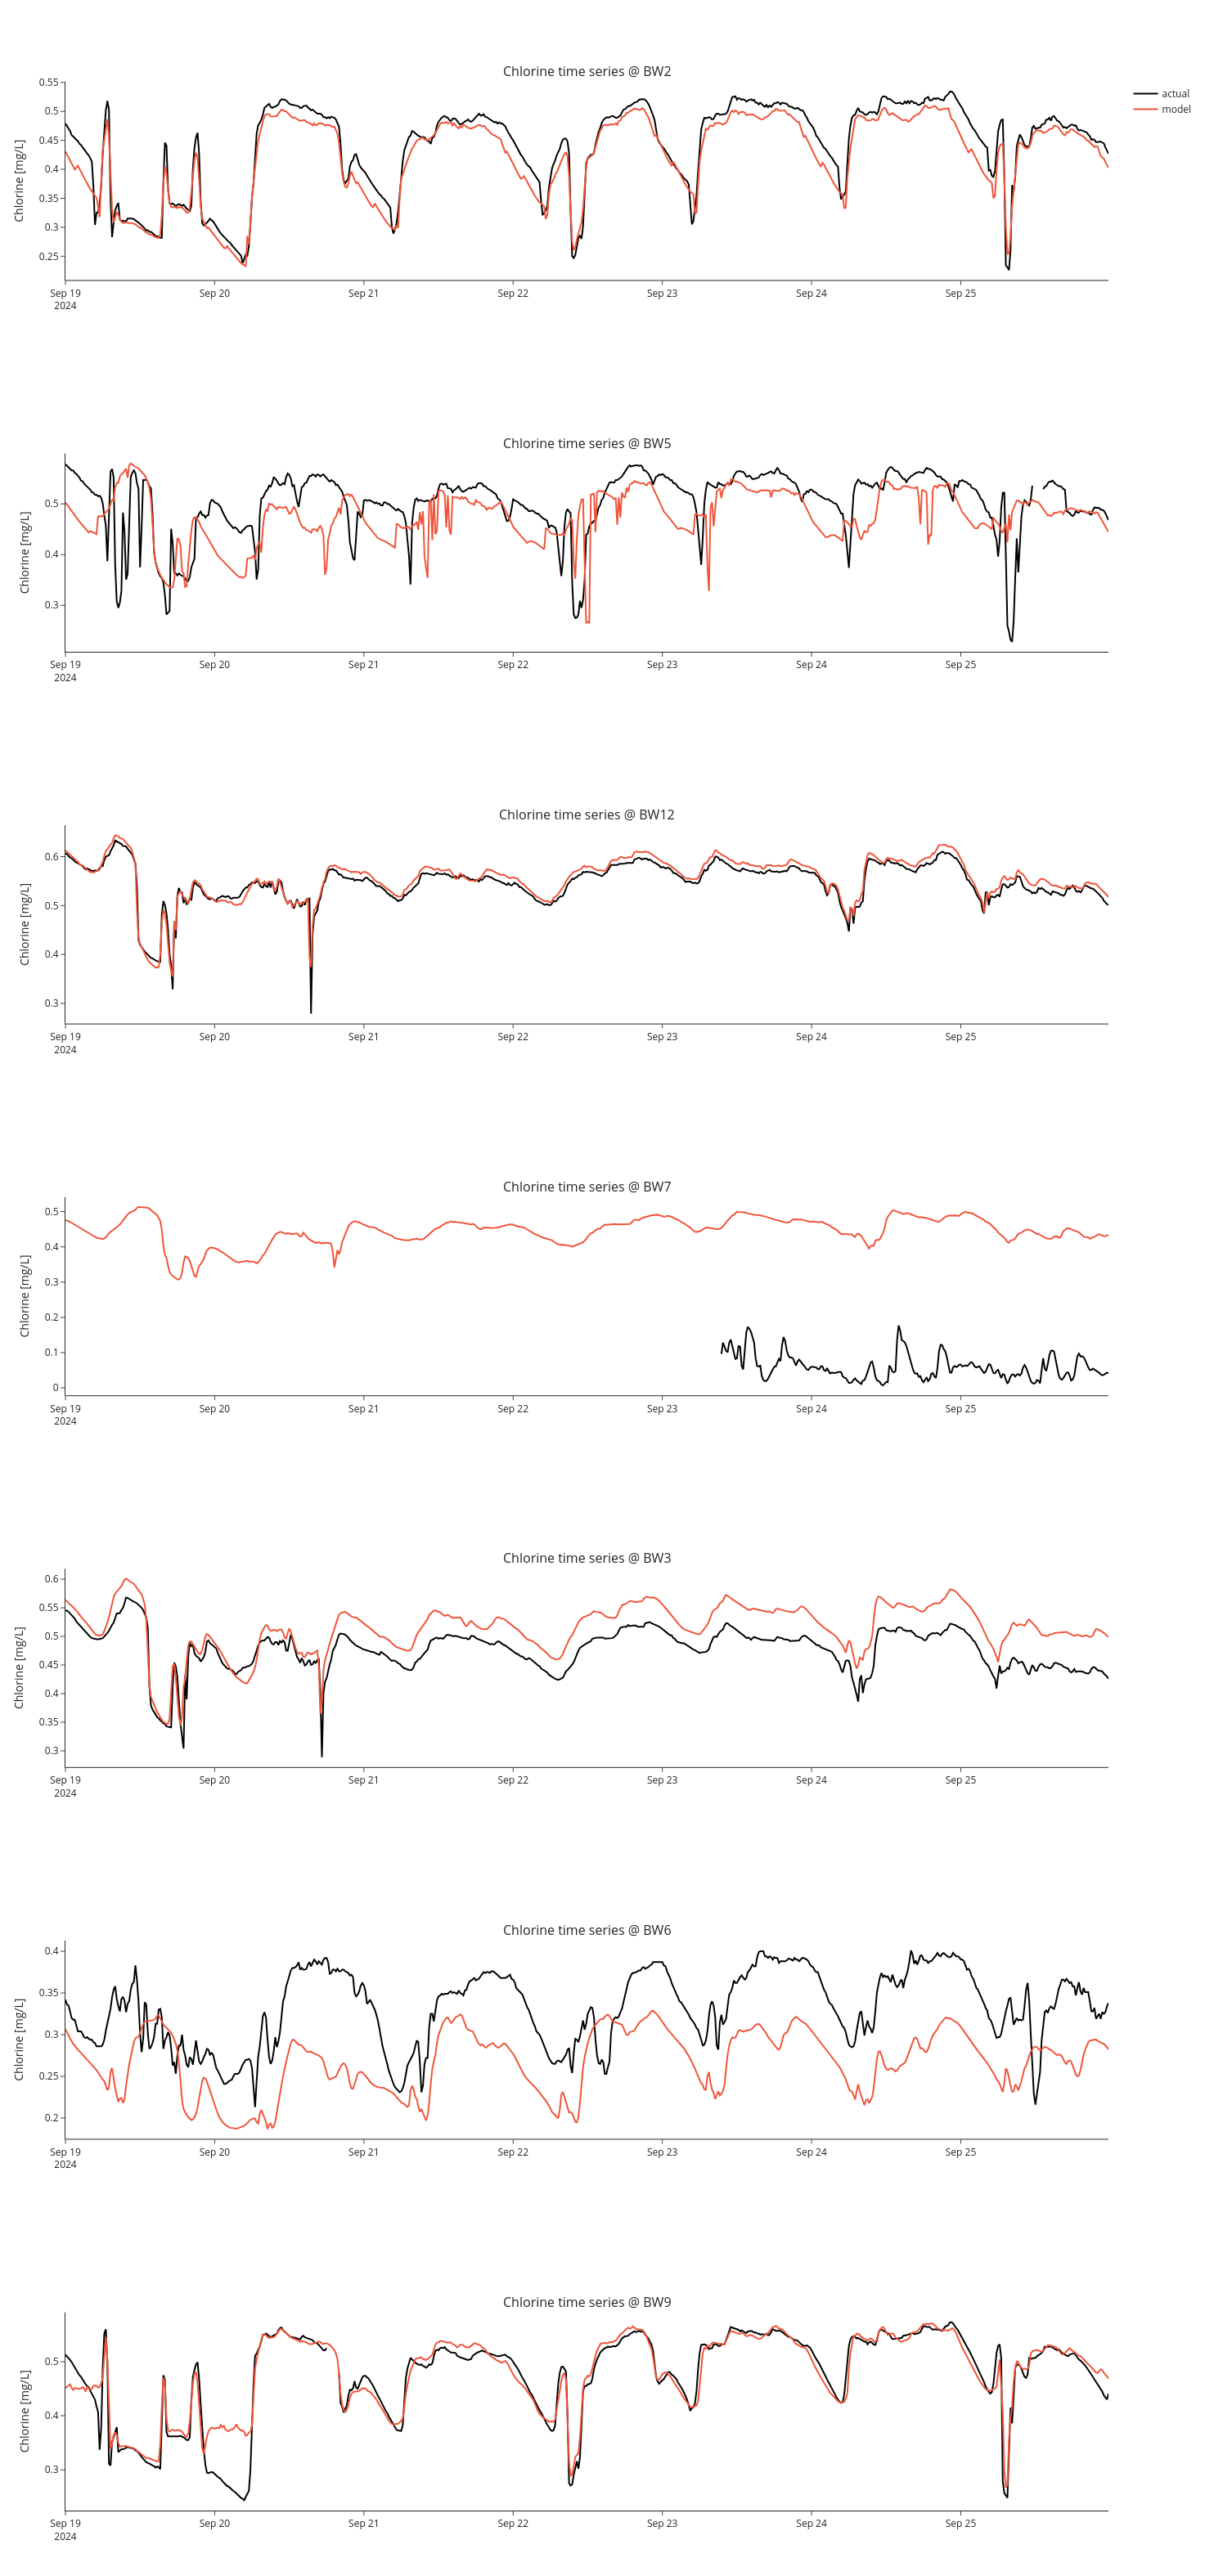

In [41]:
bwfl_ids = [bwfl_id for bwfl_id in cl_df['bwfl_id'].unique() if bwfl_id not in ['BW1', 'BW4']]
subplot_titles = [f"Chlorine time series @ {bwfl_id}" for bwfl_id in bwfl_ids]
fig = make_subplots(rows=len(bwfl_ids), cols=1, subplot_titles=subplot_titles)

for idx, bwfl_id in enumerate(bwfl_ids): 
    data = cl_df[(cl_df['bwfl_id'] == bwfl_id)]
    sim = cl_sim[bwfl_id].values
    show_legend = (idx == 0)

    # sensor data
    fig.add_trace(
        go.Scatter(
            x=data['datetime'][96:],
            y=data['mean'][96:],
            mode='lines',
            name='actual',  # Legend entry for Sensor series
            line=dict(color='black'),
            showlegend=show_legend
        ),
        row=idx + 1, col=1
    )
    
    # simulated data
    fig.add_trace(
        go.Scatter(
            x=data['datetime'][96:],
            y=sim[96:],
            mode='lines',
            name='model',
            line=dict(color=default_colors[1]),
            showlegend=show_legend
        ),
        row=idx + 1, col=1
    )
    fig.update_yaxes(title_text="Chlorine [mg/L]", row=idx + 1, col=1)

fig.update_layout(
    height=450 * len(bwfl_ids),
    template='simple_white',
    legend_title_text='',
)

fig.show()

Residual boxplots.

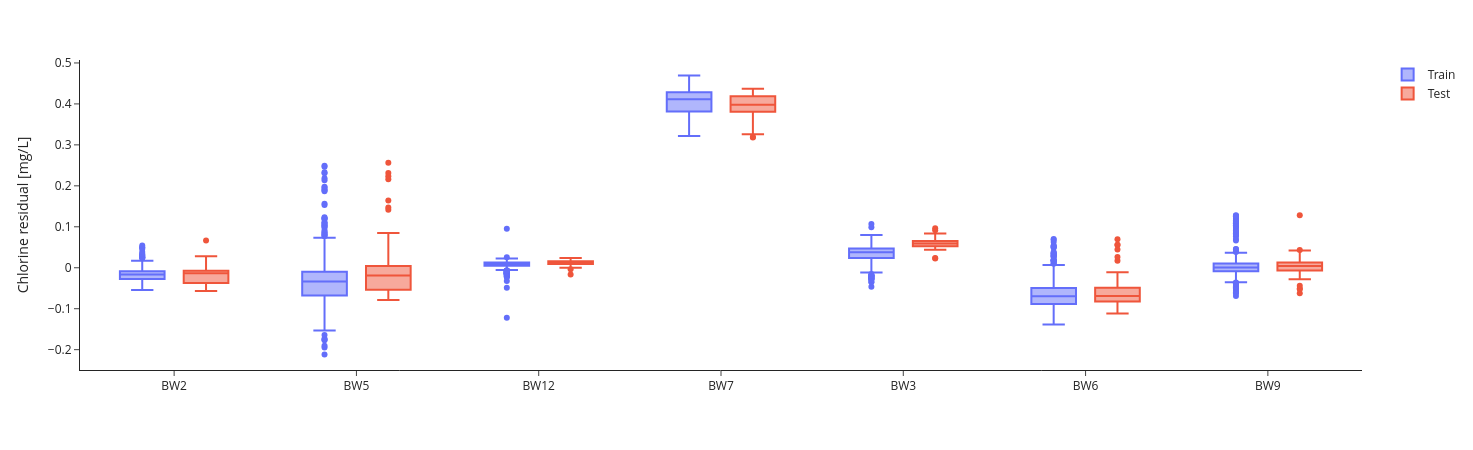

In [36]:
bwfl_ids = [bwfl_id for bwfl_id in cl_df['bwfl_id'].unique() if bwfl_id not in ['BW1', 'BW4']]

residuals_df = pd.DataFrame(columns=['bwfl_id', 'Residuals', 'Dataset'])
for bwfl_id in bwfl_ids:
    data = cl_df[cl_df['bwfl_id'] == bwfl_id]
    sim = cl_sim[bwfl_id].values
    train_residuals = sim[96:n_train] - data['mean'].values[96:n_train]
    test_residuals = sim[n_train:] - data['mean'].values[n_train:]
    
    residuals_df = pd.concat([
        residuals_df,
        pd.DataFrame({'bwfl_id': bwfl_id, 'Residuals': train_residuals, 'Dataset': 'Train'}),
        pd.DataFrame({'bwfl_id': bwfl_id, 'Residuals': test_residuals, 'Dataset': 'Test'})
    ], ignore_index=True)

fig = px.box(residuals_df, x='bwfl_id', y='Residuals', color='Dataset',
             labels={'bwfl_id': 'BWFL ID', 'Residuals': 'Residuals'},
             points='outliers')

fig.update_layout(
    height=450,
    xaxis_title='',
    yaxis_title='Chlorine residual [mg/L]',
    template='simple_white',
    legend_title_text='',
)
fig.show()

Network residuals plot.

In [ ]:
# insert code here...